In [3]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib
import numpy as np
import torch, time

from sklearn.metrics import mean_squared_error
import h5py

import neuravi
import os


# First we check if CUDA is available
print("CUDA AVAILABLE? ",torch.cuda.is_available())

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
      
device = get_default_device()
print(device)

CUDA AVAILABLE?  True
cuda


# Data Import

In [4]:
### Load dataset
ds = neuravi.data_loader("./data/DataSet_0p80val.hdf5",
                         "./data/NKAS_Raman.hdf5",
                         "./data/NKAS_density.hdf5",
                         "./data/NKAS_optical.hdf5",device)

/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


# Multitask learning effect

In [9]:
# List of networks
list_models = os.listdir("./model/exp_multitask/")

result_multitask = pd.DataFrame()
result_multitask["mean"] = np.ones(4)
result_multitask["std"] = np.ones(4)
result_multitask["name"] = ["loss_ag_myega_am_cg",
                            "loss_ag_myega_am_cg_ram",
                            "loss_ag_myega_am_cg_ram_d",
                            "loss_ag_myega_am_cg_ram_d_S_ri"]

# Loss criterion
criterion = torch.nn.MSELoss()

# Loop for changing the losses
for j in range(len(result_multitask.loc[:,"name"])):
    
    loss_ag_test = np.ones(10) # the array to store values for the 10 networks
    for i in range(10): # start to loop over the 10 networks generated to get some statistics
        
        name = result_multitask.loc[j,"name"]+"_"+str(i)+".pth"
        
        # Declare model
        neuralmodel = neuravi.model(4,200,3,ds.nb_channels_raman,p_drop=0.05) 
        neuralmodel.load_state_dict(torch.load("./model/exp_multitask/"+name, map_location='cpu'))
        neuralmodel.eval()
        
        # PREDICTIONS
        y_ag_pred_test = neuralmodel.ag(ds.x_visco_test.cpu(),ds.T_visco_test.cpu()) # test
        
        # Compute Loss 
        loss_ag_test[i] = criterion(y_ag_pred_test, ds.y_visco_test.cpu()).item() # test
    
    # record result in the Pandas result dataframe
    result_multitask.loc[j,"mean"] = loss_ag_test.mean()
    result_multitask.loc[j,"std"] = loss_ag_test.std()
    
result_multitask.to_csv("result_multitask_exp.csv")

TypeError: expected x and y to have same length

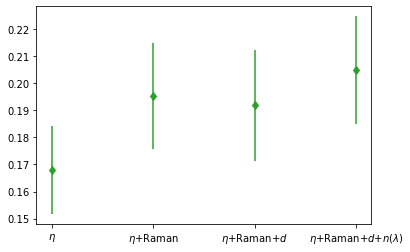

In [10]:
x_names = ["$\eta$","$\eta$+Raman","$\eta$+Raman+$d$","$\eta$+Raman+$d$+$n(\lambda)$"]

plt.errorbar(x_names,result_multitask["mean"],yerr=result_multitask["std"],fmt="d",color="C2")

plt.plot(np.arange(0,4,0.1), # X
         np.polyval(np.polyfit(np.arange(0,5,1),result_multitask["mean"],1),np.arange(0,4,0.1)), # Y
         "--",color="grey",linewidth=2
        )

plt.ylim(0,0.6)

plt.xticks(rotation=50)

plt.ylabel("mean MSE AG, test subset")

In [11]:
result_multitask

,mean,std,name
0,0.167902,0.016156,loss_ag_myega_am_cg
1,0.195226,0.019635,loss_ag_myega_am_cg_ram
2,0.191767,0.020584,loss_ag_myega_am_cg_ram_d
3,0.204762,0.019952,loss_ag_myega_am_cg_ram_d_S_ri
